# M5 Forecast Accuracy Research

The M5 Forecasting competition provides a real life data set to perform business analysis and forecast research. My goal, as a Stern freshman student, is to learn the various time series forecasting algorithms, and compare their accuracy in different types of use cases, similar to the M4 research published here. https://mofc.unic.ac.cy/m4/.

Many thanks to Professor Makridakis and the MOFC team for making the data easily available and pulling the talents from all over the world to explore and develop the wonderful world of telling the future!

During the next month, I plan to compare the following commonly used forecasting algorithms, using the Root Mean Squared Scaled Error (RMSSE) as the measurement:

* Autoregressive Integrated Moving Average (ARIMA)
* Seasonal ARIMA (SARIMA)
* Seasonal ARIMA with Excogenous Regressors (SARIMAX)
* Simple Exponential Smoothing (SES)
* Holt Winter's Exponential Smoothing (Holt)

The algorithms are explained in this Jason Brownlee here https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

As my goal is not to compete, but to learn and compare the algorithms, I plan to analyze only one store (TX_1) and aggregate at the product category level (Food, Hobbies and Household). I will skip the price dataset but will see how the events helps the forecast accuracy. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv


# Load the data and take a glance at the data

In [2]:
# Step 1: get the data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

CalendarDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv", header=0)
PricesDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv", header=0)
SalesDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv", header=0)
SubmissionDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv", header=0)

In [3]:
CalendarDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [4]:
PricesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [5]:
SalesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [6]:
SubmissionDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60980 entries, 0 to 60979
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60980 non-null  object
 1   F1      60980 non-null  int64 
 2   F2      60980 non-null  int64 
 3   F3      60980 non-null  int64 
 4   F4      60980 non-null  int64 
 5   F5      60980 non-null  int64 
 6   F6      60980 non-null  int64 
 7   F7      60980 non-null  int64 
 8   F8      60980 non-null  int64 
 9   F9      60980 non-null  int64 
 10  F10     60980 non-null  int64 
 11  F11     60980 non-null  int64 
 12  F12     60980 non-null  int64 
 13  F13     60980 non-null  int64 
 14  F14     60980 non-null  int64 
 15  F15     60980 non-null  int64 
 16  F16     60980 non-null  int64 
 17  F17     60980 non-null  int64 
 18  F18     60980 non-null  int64 
 19  F19     60980 non-null  int64 
 20  F20     60980 non-null  int64 
 21  F21     60980 non-null  int64 
 22  F22     60980 non-null

# I don't plan to use the price data. Deleting the PriceDF and SubmissionDF.

In [7]:
import os, psutil  

pid = os.getpid()
py = psutil.Process(pid)
memory_use = py.memory_info()[0] / 2. ** 30
print ('memory GB:' + str(np.round(memory_use, 2)))

memory GB:1.24


In [8]:
del PricesDF
del SubmissionDF

import gc
gc.collect()

20

# Prepare my dataset for TX_1 and aggregate to the product category level

In [9]:
TX_1_Sales = SalesDF[['TX_1' in x for x in SalesDF['store_id'].values]]
TX_1_Sales = TX_1_Sales.reset_index(drop = True)
TX_1_Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 44.6+ MB


In [10]:
# Generate MultiIndex for easier aggregration.
TX_1_Indexed = pd.DataFrame(TX_1_Sales.groupby(by = ['cat_id','dept_id','item_id']).sum())
TX_1_Indexed.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3049 entries, ('FOODS', 'FOODS_1', 'FOODS_1_001') to ('HOUSEHOLD', 'HOUSEHOLD_2', 'HOUSEHOLD_2_516')
Columns: 1913 entries, d_1 to d_1913
dtypes: int64(1913)
memory usage: 44.5+ MB


In [11]:
# Aggregate total sales per day for each sales category
Food = pd.DataFrame(TX_1_Indexed.xs('FOODS').sum(axis = 0))
Hobbies = pd.DataFrame(TX_1_Indexed.xs('HOBBIES').sum(axis = 0))
Household = pd.DataFrame(TX_1_Indexed.xs('HOUSEHOLD').sum(axis = 0))
Food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1913 entries, d_1 to d_1913
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1913 non-null   int64
dtypes: int64(1)
memory usage: 109.9+ KB


In [12]:
## Merge the aggregated sales data to the calendar dataframe based on date
CalendarDF = CalendarDF.merge(Food, how = 'left', left_on = 'd', right_on = Food.index)
CalendarDF = CalendarDF.rename(columns = {0:'Food'})
CalendarDF = CalendarDF.merge(Hobbies, how = 'left', left_on = 'd', right_on = Hobbies.index)
CalendarDF = CalendarDF.rename(columns = {0:'Hobbies'})
CalendarDF = CalendarDF.merge(Household, how = 'left', left_on = 'd', right_on = Household.index)
CalendarDF = CalendarDF.rename(columns = {0:'Household'})
CalendarDF.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Food,Hobbies,Household
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1781.0,251.0,524.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1903.0,264.0,520.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1377.0,107.0,338.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1643.0,248.0,367.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,1329.0,102.0,263.0
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1,2091.0,292.0,351.0
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0,1247.0,89.0,355.0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1,2008.0,264.0,548.0
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,2061.0,242.0,584.0
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0,1579.0,127.0,468.0


In [13]:
# Store a copy of the new data frame for my future use. Delete the SalesDF to save memory usage.
CalendarDF.to_csv("CalendarDF.csv", index = False)
del SalesDF
gc.collect()
memory_use = py.memory_info()[0] / 2. ** 30
print ('memory GB:' + str(np.round(memory_use, 2)))

memory GB:0.7


# Do some graphing to look at the data.
I referenced this notebook for the graphing. https://www.kaggle.com/risheshg/m5-accuracy-starter-data-exploration. There are a lot more to learn in plotting the data. But for now, I will pause.

For next week, I plan to start use the CalendarDF to do time-series analysis. 

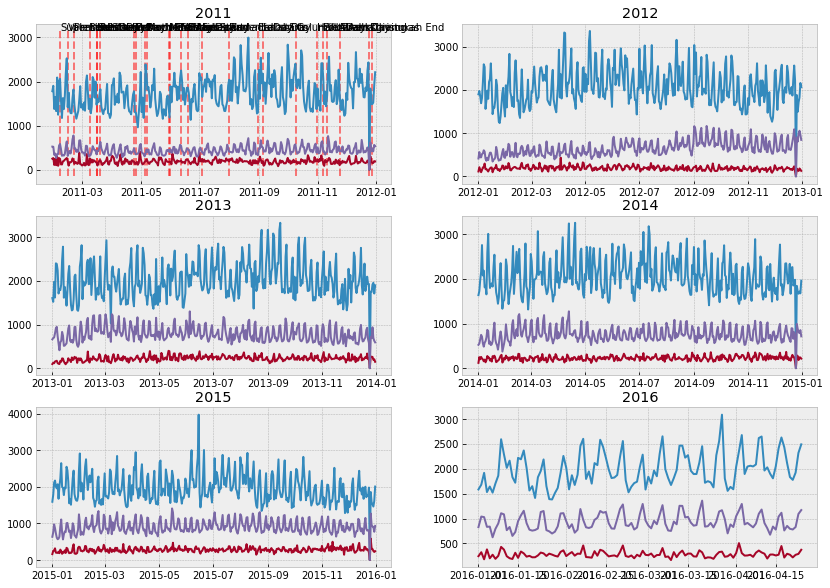

In [14]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

CalendarDF['date'] = pd.to_datetime(CalendarDF.date)
## graph daily sales data for each year 
is_2011 = CalendarDF.year == 2011
is_2012 = CalendarDF.year == 2012
is_2013 = CalendarDF.year == 2013
is_2014 = CalendarDF.year == 2014
is_2015 = CalendarDF.year == 2015
is_2016 = CalendarDF.year == 2016

temp = CalendarDF[is_2011]
temp2 = CalendarDF[is_2012]
temp3 = CalendarDF[is_2013]
temp4 = CalendarDF[is_2014]
temp5 = CalendarDF[is_2015]
temp6 = CalendarDF[is_2016]

fig, axs = plt.subplots(3 , 2, figsize = (14,10))
axs[0,0].title.set_text('2011')
axs[0 , 1].title.set_text('2012')
axs[1 , 0].title.set_text('2013')
axs[1 , 1].title.set_text('2014')
axs[2 , 0].title.set_text('2015')
axs[2 , 1].title.set_text('2016')

axs[0,0].plot(temp.date, temp.Food)
axs[0,0].plot(temp.date, temp.Hobbies)
axs[0,0].plot(temp.date, temp.Household)

df = temp[temp.event_name_1.notnull()]
df.reset_index(drop=True)

l1 = list(df['date'])
l2 = list(df['event_name_1'])

start, end = axs[0,0].get_ylim()[0], axs[0,0].get_ylim()[1]

axs[0,0].vlines(l1, start, end, linestyles = '--', color = 'r', alpha = .5)
for i in range(0,len(l2)):
    if l2[i] is not None:
       axs[0,0].text(l1[i],end,l2[i])
        
axs[0,1].plot(temp2.date, temp2.Food)
axs[0,1].plot(temp2.date, temp2.Hobbies)
axs[0,1].plot(temp2.date, temp2.Household)

axs[1,0].plot(temp3.date, temp3.Food)
axs[1,0].plot(temp3.date, temp3.Hobbies)
axs[1,0].plot(temp3.date, temp3.Household)

axs[1,1].plot(temp4.date, temp4.Food)
axs[1,1].plot(temp4.date, temp4.Hobbies)
axs[1,1].plot(temp4.date, temp4.Household)

axs[2,0].plot(temp5.date, temp5.Food)
axs[2,0].plot(temp5.date, temp5.Hobbies)
axs[2,0].plot(temp5.date, temp5.Household)

axs[2,1].plot(temp6.date, temp6.Food)
axs[2,1].plot(temp6.date, temp6.Hobbies)
axs[2,1].plot(temp6.date, temp6.Household)

plt.show()